# 사전학습모델을 이용한 이미지 판정

In [1]:
import warnings
warnings.filterwarnings(action='ignore')
 
import random
import sys
  
import numpy as np
import tensorflow as tf
  
import cv2
  
import matplotlib
import matplotlib.pyplot as plt
 
from matplotlib import font_manager, rc
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import to_categorical
 
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img
  
from sklearn.preprocessing import LabelEncoder  # class가 문자열인경우 변환
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋을 나눔
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증
 
 
 
# 기본 제공 데이터 
from keras.datasets import mnist
from keras.datasets import cifar10
 
# -----------------------------------------------------------------------------------------
# CNN 테스트시 failed to create cublas handle: CUBLAS_STATUS_ALLOC_FAILED 에러 발생시 추가
config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 1.0 # 메모리를 사전에 모두 할당
config.gpu_options.allow_growth = True                     # 메모리를 필요시 할당
session = tf.Session(config=config)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True)) # 연결된 device 확인
# -----------------------------------------------------------------------------------------
 
font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
# windows 10
# font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgunsl.ttf").get_name()
rc('font', family=font_name)           # 맑은 고딕 폰트 지정
plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정
 
# Jupyter에게 matplotlib 그래프를 출력 영역에 표시할 것을 지시하는 명령
%matplotlib inline  
 
LOG_DIR = '../../logs' # 폴더명만 지정하면 자동으로 생성됨.
 
# tensorboard --logdir=C:/ai_201904/ws_python/notebook/logs 
# graph = tf.get_default_graph()
# with tf.summary.FileWriter(LOG_DIR) as writer:
#     writer.add_graph(graph)
 
   
 

Using TensorFlow backend.


In [2]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

import numpy as np
model = VGG16()

553467904/553467096 [==============================] - 175s 0us/step


In [3]:
from tensorflow.python.keras.applications.vgg16 import VGG16


# 처음 호출할 때는 모델을 내려받기 때문에 시간이 걸린다
model = VGG16()

In [4]:
# 모델의 요약을 확인. 입력층의 크기는 224X224,출력층은 1000클래스의 확률이 출력되는 구성으로 되어있다.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [5]:
from tensorflow.python.keras.preprocessing.image import load_img


# 이미지 불러오기. load_img()에서는 불러올 때 이미지를 리사이즈할 수 있으므로 VGG16의 입력
#사이즈인 224×224로 리사이즈합니다.
img_dog = load_img('./images/dog.jpg', target_size=(224, 224))
img_cat = load_img('./images/cat.jpg', target_size=(224, 224))

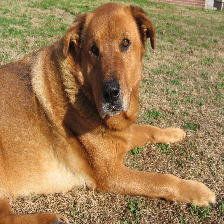

In [6]:
img_dog

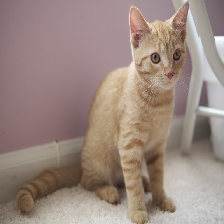

In [7]:
img_cat

In [8]:
from tensorflow.python.keras.preprocessing.image import img_to_array


# load_img()는 Pillow라고 부르는 이미지 라이브러리의 데이터 형식이므로 그대로는 이용할 수 없다.
# 일반적인 수치 데이터로 취급하기 위해 numpy.ndarrya로 변환
arr_dog = img_to_array(img_dog)
arr_cat = img_to_array(img_cat)

In [9]:
from tensorflow.python.keras.applications.vgg16 import preprocess_input

# 이미지 각 채널의 중심화와 RGB로부터 BGR로 변환
# 이미지를 VGG16 모델이 학습할 때와 같은 형태로 맞춰서 변환
arr_cat = preprocess_input(arr_cat)
arr_dog = preprocess_input(arr_dog)

In [10]:
import numpy as np


# 일반적인 판별 모델은 여러 장의 이미지・데이터를 한 번에 입력해서 ➡ 데이터의 수만큼 결과를
# 출력할 수 있다.
# 개와 고양이의 이미지를 합쳐서, 두 장의 이미지를 포함하는 배열로 입력 데이터를 변환
arr_input = np.stack([arr_dog, arr_cat])

In [11]:
# 입력 데이터의 shape를 확인
print('shape of arr_input:', arr_input.shape)

shape of arr_input: (2, 224, 224, 3)


In [13]:
# 예측값(확률)을 산출
# 추론에서는 2X1000의 2차원 배열이 출력됨
probs = model.predict(arr_input)

# 예측값의 shape를 확인
print('shape of probs:', probs.shape)

# 예측값 표시
probs

shape of probs: (2, 1000)


array([[1.3260074e-06, 2.6298713e-07, 1.9136262e-07, ..., 3.4285924e-07,
        4.2921852e-06, 4.3677948e-05],
       [6.1585945e-07, 6.2430654e-06, 2.1850442e-06, ..., 6.7036183e-07,
        1.7082116e-04, 7.0913392e-03]], dtype=float32)

In [14]:
from tensorflow.python.keras.applications.vgg16 import decode_predictions


# 예측 결과는 1000 클래스 각각의 확률만 반환하기 때문에
# 클래스 이름을 판단하기 어려우므로
# decode_predictions()을 사용해서 알기 쉬운 결과로 변환하고, 상위 5개를 표시
results = decode_predictions(probs)

40960/35363 [==================================]40960/35363 [==================================] - 0s 5us/step



In [15]:
# 개 이미지의 결과를 표시(상위 5개)
results[0]

[('n02087394', 'Rhodesian_ridgeback', 0.5825013),
 ('n02090379', 'redbone', 0.13647173),
 ('n02099601', 'golden_retriever', 0.05809515),
 ('n02088466', 'bloodhound', 0.055783473),
 ('n02106662', 'German_shepherd', 0.03908471)]

In [16]:
# 고양이 이미지의 결과를 표시(상위 5개)
results[1]

[('n02123159', 'tiger_cat', 0.2986854),
 ('n02124075', 'Egyptian_cat', 0.25323755),
 ('n02123045', 'tabby', 0.16191167),
 ('n02127052', 'lynx', 0.060164504),
 ('n04265275', 'space_heater', 0.024290906)]

In [17]:
# Strawberry
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
import numpy as np
model = VGG16()

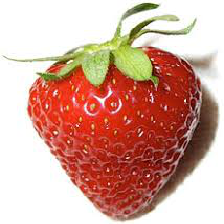

In [18]:
img_strawberry = load_img('./images/strawberry.jpg', target_size=(224, 224))
img_strawberry


In [19]:
arr_strawberry = img_to_array(img_strawberry)
arr_strawberry = preprocess_input(arr_strawberry)
arr_input = np.stack([arr_strawberry])
print('shape of arr_input:', arr_input.shape)


shape of arr_input: (1, 224, 224, 3)


In [20]:
probs = model.predict(arr_input)
print('shape of probs:', probs.shape)
probs


shape of probs: (1, 1000)


array([[8.84044140e-12, 1.57320041e-08, 2.25269421e-11, 8.28258469e-12,
        4.94444633e-12, 1.87845783e-09, 2.22889259e-11, 4.24454186e-07,
        3.38584982e-08, 4.40911474e-11, 2.45504977e-10, 7.39274530e-10,
        1.88758054e-09, 2.40827080e-11, 8.31881300e-11, 5.95422378e-10,
        2.41114573e-09, 1.22360871e-10, 7.87595891e-11, 4.58061054e-11,
        1.27318867e-11, 2.18720406e-11, 2.28649695e-12, 1.70585750e-11,
        5.70870001e-12, 1.54474246e-11, 7.84673437e-11, 7.05296932e-10,
        1.12768635e-10, 1.25816427e-10, 6.96578489e-11, 1.46274071e-09,
        8.21451740e-10, 1.34661093e-11, 3.25481070e-12, 1.64691837e-11,
        2.50422572e-10, 3.34118740e-11, 3.35762494e-11, 3.13092996e-10,
        6.23779872e-09, 2.69417873e-11, 4.48364193e-11, 7.00436497e-12,
        2.09166764e-11, 5.88442850e-10, 2.46753817e-09, 2.92221178e-11,
        9.29594509e-12, 1.69438474e-11, 4.20725468e-11, 1.96421754e-10,
        3.49738460e-10, 1.16615786e-10, 5.82651774e-11, 2.630099

In [21]:
results = decode_predictions(probs)
results[0]

[('n07745940', 'strawberry', 0.9996574),
 ('n07747607', 'orange', 7.736984e-05),
 ('n04332243', 'strainer', 5.901517e-05),
 ('n07753592', 'banana', 4.4112225e-05),
 ('n07749582', 'lemon', 2.4071209e-05)]